In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.time import Time 
from astropy.stats import sigma_clip
from scipy.stats import norm
from scipy.special import erfc
# http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.norm.html


## Plot 1 : Generate sinusoidal lightcurve, consider Gaussian sampling with Euclidean counts

In [3]:
dir_save = '/astro/users/suberlak/S13Agg_analysis/data_products/'

This means that we make a time-series where 
F_true  = A*sin(t)+B

and 
sigma = constant = 25-th percentile of sorted  F_true distribution (which with A=1 and B=1 ranges from 0 to 2 ) 

then we scale the distribution of F_true values by sigma, thus considering x_true = F_true  / sigma . 

The observed points corresponding to each F_true are drawn from a Gaussian distribution   ($p(F) \sim \mathcal{N}(F_{true}, \sigma)$), centered on F_true, with a width sigma.   For a scaled x_true,  the distribution is centered on x_true, with a width of 1.

If the number of possible sources was constant with decreasing flux (increasing magnitudes), then the plot of x_true vs x_obs, assuming we draw a 100 observations at the same time of each x_true , so that there are 100 values of x_obs for each x_true  would be : 


In [7]:
# Generate 1000 true points 
time = np.linspace(start=0,stop=2*np.pi, num=100)
f_true = np.sin(time)+1.0

# Define  a sigma as 20% of the 25-th percentile .. 
sigma = np.percentile(f_true,25)
x_true = f_true / sigma 
# For each of those points, generate a Gaussian distribution of points, with a width of sigma
x_obs = []  # store 1000 arrays of 100 Gaussian draws each 
for i in range(len(x_true)):
    # draw a 100 points from a Gaussian centered on x_true, width of sigma (=1 since scaled by sigma )
    x_obs_i = np.random.normal(loc=x_true[i], scale = 1, size = 100)
    x_obs.append(x_obs_i)


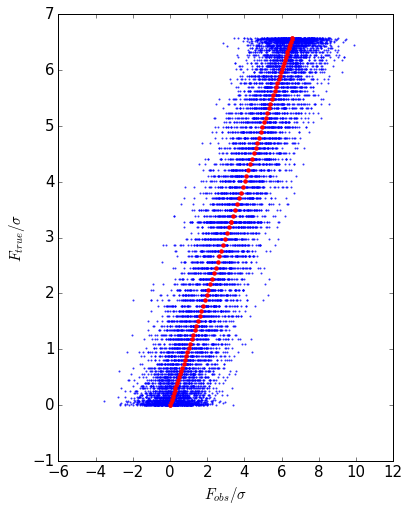

In [8]:
%matplotlib inline
fig, ax= plt.subplots(figsize=(6,8))

for i in range(len(x_true)):
    x_obs_i = x_obs[i]
    x_true_i = x_true[i]
    #if (x_true_i < 3.2) & (x_true_i > 3 ) : 
    x_true_arr =  np.ones_like(x_obs_i) * x_true_i
    ax.scatter(x_obs_i, x_true_arr, lw=0, s=4, alpha=0.8 )
    ax.scatter(x_true_i, x_true_i, color='red', lw=0)
ax.set_ylabel(r'$F_{true} / \sigma$', fontsize=15)
ax.set_xlabel(r'$F_{obs} / \sigma$', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.savefig(dir_save+'Sim_LC_x_obs_vs_x_true_constant_counts.png')

However, the total number of sources increases with decreasing flux (increasing magnitudes), according to Euclidean cumulative distribution function:

$N(>F) \propto F ^{-1.5}$  , or $N(<m) \propto 10^ {0.6 m }$

this means that our distribution of possible flux as we go to fainter objects (lower S/N) becomes wider , as there is more x_obs points per each x_true towards the faint end : 

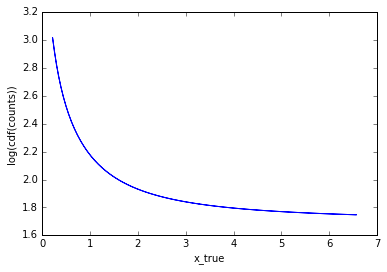

In [11]:
# Generate 1000 true points 
time = np.linspace(start=0,stop=2*np.pi, num=100)
f_true = np.sin(time)+1.0

# Define  a sigma as 20% of the 25-th percentile .. 
sigma = np.percentile(f_true,25)
x_true = f_true / sigma 

# Choose points with S/N > 0.2 ... 
n0 = 100
mask_close_zero = x_true>0.2
n = n0 * x_true[mask_close_zero] **(-1.5)+50
plt.plot(x_true[mask_close_zero], np.log10(n))
plt.xlabel('x_true')
plt.ylabel('log(cdf(counts))')

Make a plot that shows how for each x_true we draw  x_obs points ,  where number of points comes from an Euclidean cdf, which describes  N(x > x_true).  Thus I need to recover the pdf from the cdf to get N(x = x_true):

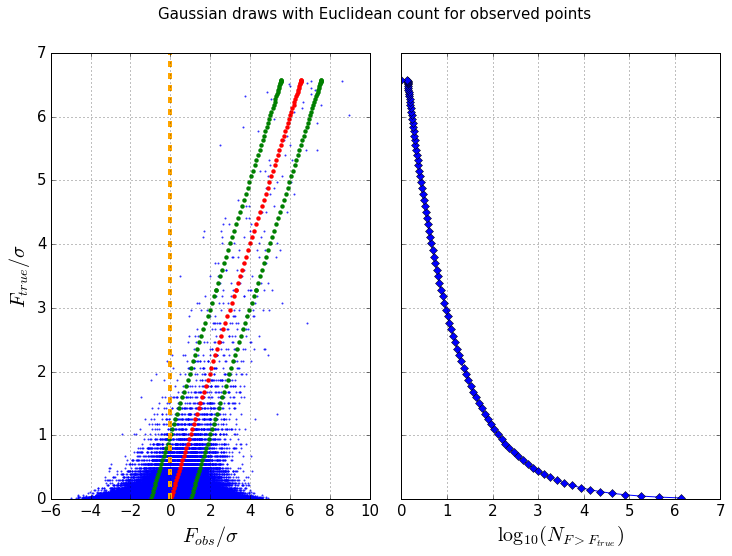

In [12]:
# Generate N true points 
time = np.linspace(start=0,stop=2*np.pi, num=100)
f_true = np.sin(time)+1.0

# Define  a sigma as 20% of the 25-th percentile .. 
sigma = np.percentile(f_true,25)
x_true = f_true / sigma 

# grab only points that are far enough from 0 
# that the number of counts does not become exponentially large... 
mask_close_zero = x_true>0.02

sorted_x = np.sort(x_true[mask_close_zero])

n_counts_cdf = n0 * sorted_x **(-1.5)+50
n_counts_pdf = np.ones_like(n_counts_cdf)

for i in range(len(sorted_x)-1):
    rise = n_counts_cdf[i] - n_counts_cdf[i+1]
    run  = abs(sorted_x[i+1] - sorted_x[i])
    n_counts_pdf[i] = rise / run 

n_counts = n_counts_pdf

# For each of those points, generate a Gaussian distribution of points, with a width of sigma
x_obs = []  # store 1000 arrays of N(F) Gaussian draws each 

for i in range(len(sorted_x)):
    # draw a 100 points from a Gaussian centered on x_true, width of sigma (=1 since scaled by sigma )
    n = n_counts[i].astype(int)
    x_obs_i = np.random.normal(loc=sorted_x[i], scale = 1, size = n)
    x_obs.append(x_obs_i)

%matplotlib inline
fig, ax= plt.subplots(1,2,figsize=(12,8), sharey=True)

for i in range(len(sorted_x)):
    x_obs_i = x_obs[i]
    x_true_i = sorted_x[i]
    #if (x_true_i < 3.2) & (x_true_i > 3 ) : 
    x_true_arr =  np.ones_like(x_obs_i) * x_true_i
    ax[0].scatter(x_obs_i, x_true_arr, lw=0, s=4, alpha=0.8 )
    # mark the mean , the mean of underlying gaussian, i.e. x_true
    ax[0].scatter(x_true_i, x_true_i, color='red', lw=0)
    # mark the +/-  1 sigma level, where we expect 68% of points to be 
    ax[0].scatter(x_true_i-1, x_true_i, color='green', lw=0)
    ax[0].scatter(x_true_i+1, x_true_i, color='green', lw=0)
ax[1].plot(np.log10(n_counts), sorted_x, marker='D')

fig.subplots_adjust(wspace=0.1)
ax[0].set_ylabel(r'$F_{true} / \sigma$', fontsize=20)
ax[0].set_xlabel(r'$F_{obs} / \sigma$', fontsize=20)
ax[1].set_xlabel(r'$\log_{10}(N_{F>F_{true}})$', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[0].grid()
ax[1].grid()
ax[0].axvline(x=0, color='orange', ls='--', lw=4)
#plt.tight_layout()
fig.suptitle('Gaussian draws with Euclidean count for observed points', fontsize=15)
plt.savefig(dir_save+'Sim_LC_x_obs_vs_x_true_Euclidean_counts.png')

## Plot 2 : Illustrate p(F)  for a faint point with negative distribution tails

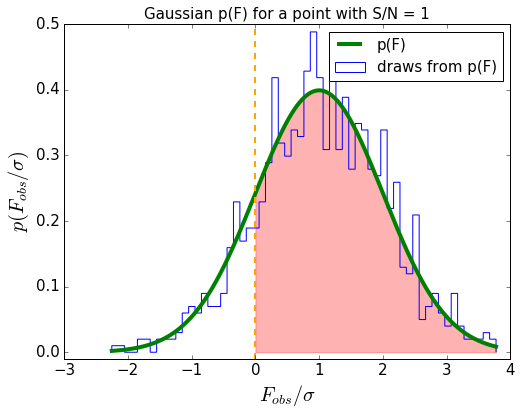

In [36]:
from scipy.stats import norm

x_true = 1
width = 1
#np.random.seed(24)
x_obs = np.random.normal(loc=x_true, scale = width, size = 1000)
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(x_obs, normed=True, bins=60, histtype='step' , label='draws from p(F)')

# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(min(x_obs), max(x_obs), 0.001)
# Mean = 0, SD = 2.
ax.plot(x_axis,norm.pdf(x_axis,x_true,width), lw=4 , label='p(F)')

# mark the zero
ax.axvline(0,lw=2,ls='--', color='orange')

# mark the posterior
# ax.plot([x1,x2], [y1,y2]) to draw a line from x1,y1 to x2,y2
#ax.plot([min(x_obs), 0], [0, 0], ls='-', color='red', lw=4)
#ax.plot([0,0], [0,norm.pdf(0,x_true,width)],ls='-', color='red', lw=4)

# shade the positive part 
mask = x_axis>0
ax.fill_between(x_axis[mask],norm.pdf(x_axis[mask],x_true,width), alpha=0.3, color='red' )

ax.set_ylim(-.01)
ax.set_ylabel(r'$p(F_{obs}/\sigma)$', fontsize=20)
ax.set_xlabel(r'$F_{obs}/\sigma$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
# save the plot 
ax.set_title('Gaussian p(F) for a point with S/N = 1', fontsize=15)
ax.legend(fontsize=15)
plt.savefig(dir_save + 'Sim_LC_illustrate_pF_mean_1_width_1.png')

## Plot 3 : Illustrate the magnitude depth recovered  by faint signal treatment beyond  $2\sigma$...  

Euclidean number of counts in relation to magnitude obeys : 
    
$N(m) \propto 10^{0.6m}$

In [323]:
ax.text?

2 sigma limit mag is 23.881135
5 sigma limit mag is 22.886285


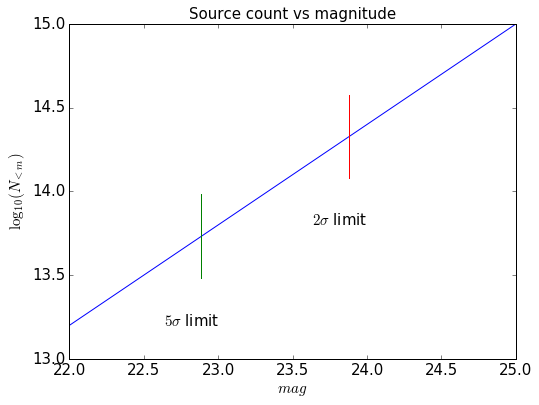

In [37]:
m = np.linspace(22,25,100)
mean_sigma = np.median(fp_data['psfFluxErr'].values) #1.2E-30
m_2sig = -2.5 * np.log10(2*mean_sigma) - 48.6
m_5sig = -2.5 * np.log10(5*mean_sigma) - 48.6
print('2 sigma limit mag is %f'%m_2sig)
print('5 sigma limit mag is %f'%m_5sig)
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(m, np.log10(10**(0.6*m)))

# plot 5 sigma limit 
linesize = 0.25
y1y2 = [ np.log10(10**(0.6*m_5sig))-linesize,np.log10(10**(0.6*m_5sig))+linesize]
x1x2 = [m_5sig, m_5sig ]
ax.plot(x1x2, y1y2)
ax.text(x=m_5sig-0.25,y=13.2,s=r'$5 \sigma$ limit', fontsize=15)

# plot 2 sigma limit 
linesize = 0.25
y1y2 = [ np.log10(10**(0.6*m_2sig))-linesize,np.log10(10**(0.6*m_2sig))+linesize]
x1x2 = [m_2sig, m_2sig ]
ax.plot(x1x2, y1y2)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.text(x=m_2sig-0.25,y=13.8,s=r'$2 \sigma$ limit', fontsize=15)
ax.set_xlabel(r'$mag$', fontsize=15)
ax.set_ylabel(r'$\log_{10}(N_{<m})$', fontsize=15)
ax.set_title('Source count vs magnitude', fontsize=15)
plt.savefig(dir_save+'Source_count_vs_magnitude.png')

I could measure the N(m) : take several thousands of the raw FP lightcurves, do the faint-point treatment, recalculate to magnitudes, and plot how many points do we have in total up to a certain magnitude (cumulative distribution)

In [32]:

DirIn = '/astro/store/scratch/tmp/suberlak/S13Agg/rawDataFPSplit/'
name = 'g00_21.csv'
fp_data = pd.read_csv(DirIn+name+'.gz', compression='gzip',  
                     usecols=['objectId', 'mjd', 'psfFlux', 'psfFluxErr'], nrows=10000)


In [33]:
import sys
sys.path.insert(0, '/astro/users/suberlak/S13Agg_analysis/packages/')
import faintFunctions as faintF 

In [34]:
####  first drop all NaNs  in psfFlux...      
m1  = np.isnan(fp_data['psfFlux'])  # True if NaN  
m2 =  ~np.isfinite(fp_data['psfFlux']) #  True if not finite  
m  = m1 | m2  # a logical or 
if np.sum(m) > 0 :  # only apply if there is anything to drop ... 
    fp_data.drop(m.index[m], inplace=True)  # drop entire rows 
    print('Okay, we dropped %d rows where psfFlux is NaN or inf'%np.sum(m))

#### check to make sure that there are no NaN or 0 psfFluxErr... 
m1  = np.isnan(fp_data['psfFluxErr'])  # True if NaN  
m2 =  ~np.isfinite(fp_data['psfFluxErr']) #  True if not finite
m3 =   fp_data['psfFluxErr'].values == 0 # True if Err == 0  (IN2P3 problem...)
m  = m1 | m2 | m3  # a logical or 
if np.sum(m) > 0 :  # only apply if there is anything to drop ... 
    fp_data.drop(m.index[m], inplace=True)
    print('Okay, we dropped %d rows where psfFluxErr is NaN or inf'%np.sum(m))

# make a new column, fill with 0's
fp_data['flagFaint'] = 0

# mask those rows that correspond to SNR < 2
mask = (fp_data['psfFlux'].values / fp_data['psfFluxErr'].values) < 2

# print info how many points are affected
print('There are %d points of %d that have SNR<2' %(np.sum(mask),len(mask)))

# set flag at those rows to 1
fp_data.ix[mask, 'flagFaint'] = 1

# make new columns for  Mean  Median  2 sigma...
fp_data['faintMean'] = np.nan
fp_data['faintMedian'] = np.nan
fp_data['faintTwoSigma'] = np.nan
fp_data['faintRMS'] = np.nan
# calculate the faint replacement only for faint points...
print('Faint points treatment...')
fp_data.ix[mask, 'faintMean'] = faintF.calculate_mean(fp_data['psfFlux'][mask].values,fp_data['psfFluxErr'][mask].values)
fp_data.ix[mask, 'faintMedian'] = faintF.calculate_median(fp_data['psfFlux'][mask].values,fp_data['psfFluxErr'][mask].values)
fp_data.ix[mask, 'faintTwoSigma'] = faintF.calculate_2sigma(fp_data['psfFlux'][mask].values,fp_data['psfFluxErr'][mask].values)
fp_data.ix[mask, 'faintRMS'] = faintF.calculate_rms(fp_data['psfFlux'][mask].values,fp_data['psfFluxErr'][mask].values)

#
##########  STEP 2 : Derived Quantities ###########  
#

####  replace all psfFlux  where SNR < 2  with  faintMean  
rows = fp_data['flagFaint'] == 1
fp_data.ix[rows, 'psfFlux'] = fp_data.ix[rows, 'faintMean']

def flux2absigma(flux, fluxsigma):
  """Compute AB mag sigma given flux and flux sigma"""
  FIVE_OVER_2LOG10 = 1.085736204758129569
  return FIVE_OVER_2LOG10 * fluxsigma / flux;


def flux2ab(flux):
  """Compute AB mag given flux"""
  return -2.5 * np.log10(flux) - 48.6;

fp_data['psfMag'] = flux2ab(fp_data['psfFlux'])
fp_data['psfMagErr'] = flux2absigma(fp_data['psfFlux'],fp_data['psfFluxErr'])

print('Calculating magnitudes from fluxes is finished')

There are 5464 points of 10000 that have SNR<2
Faint points treatment...
Calculating magnitudes from fluxes is finished


offset b=-10.406611


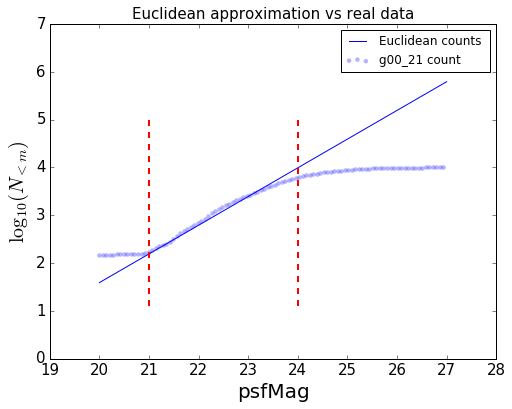

In [38]:
m = np.linspace(20,27,100)
N_cumulative = np.zeros_like(m)
N_between_m = np.zeros_like(m)
for i in range(len(m)-1):
    N_between_m[i] = np.sum((fp_data['psfMag'].values >m[i])&(fp_data['psfMag'].values <m[i+1]))
    N_cumulative[i] = np.sum(fp_data['psfMag'].values < m[i])
    

from scipy.optimize import curve_fit

def func(m, b):
    return np.log10(10**(0.6*m))+b

mask = (m>22) & (m<24)
popt, pcov = curve_fit(func, m[mask], np.log10(N_cumulative[mask]))

fig,ax = plt.subplots(figsize=(8,6))
ax.scatter(m, np.log10(N_cumulative),  label='g00_21 count', alpha=0.3, lw=0)
ax.plot(m, func(m,popt[0]), label='Euclidean counts ')
ax.legend(loc='best', fontsize=12)
ax.set_ylabel(r'$\log_{10}(N_{<m})$', fontsize=20)
ax.set_xlabel('psfMag', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.plot([21,21],[1.1,5], color='red', ls='--', lw=2)
ax.plot([24,24],[1.1,5], color='red', ls='--', lw=2)
ax.set_title('Euclidean approximation vs real data', fontsize=15)
plt.savefig(dir_save+'Simulated_vs_obs_counts_one_patch_raw_FP.png')
print('offset b=%f'%popt[0])

The plot above shows the cdf of counts up to a given magnitude. In a window of $21<m<24$ we fitted functional form  $N = 10^{0.6m}+b$, with best fit offset   $b=-10.4$